In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import awkward as ak
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

import time

from hist import Hist

import babar_analysis_tools as bat
from analysis_variables import *
import myPIDselector

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import joblib

In [2]:
'''
start= time.time()

## My laptop
#topdir= "/Users/josieswann/BaBar_analyses/BNV_pLambda/"

## Bellis computer
topdir= "/home/bellis/babar_data/bnv_plambda"
#topdir= "/home/bellis/babar_data/bnv_plambda_bnc"


filename= f"{topdir}/Background_and_signal_SP_modes_Only_Run_1.parquet"
#filename= f"{topdir}/Background_and_signal_SP_modes_All_runs.parquet" ## this won't run on mine 
#filename= f"{topdir}/Background_and_signal_SP_modes_BNC_Only_Run_1.parquet"
#filename= f"{topdir}/Background_and_signal_SP_modes_BNC_All_runs.parquet"

data= ak.from_parquet(filename)

print(f"Took {time.time()-start} seconds")

IS_MC= True

#Collision data 

#filename = f'{topdir}/Background_SP_modes_Only_Run_1.parquet'
filename = f'{topdir}/Data_Only_Run_1_BLINDED.parquet'
#filename = f'{topdir}/Data_All_runs_BLINDED.parquet'
#filename = f'{topdir}/Data_All_runs_BLINDED.parquet'
#filename = f'{topdir}/Data_BNC_Only_Run_1.parquet'
#filename = f'{topdir}/Data_BNC_All_runs.parquet'

start= time.time()
data_collision= ak.from_parquet(filename)

print(f"took {time.time()-start} seconds")

print(type(data_collision))
''';

In [3]:
#####################################################################
# Where are we running this?
#####################################################################
## Bellis computer
topdir= "/home/bellis/babar_data/bnv_plambda"

## My laptop
#topdir= "/Users/josieswann/BaBar_analyses/BNV_pLambda/"
#####################################################################


#####################################################################
# Get the BNV data
#####################################################################
#data, data_collision = bat.load_datasets(topdir=topdir)

#####################################################################
# Get the BNC data
#####################################################################
topdir= "/home/bellis/babar_data/bnv_plambda_bnc"
data, data_collision = bat.load_datasets(topdir=topdir, BNC=True, subset='all')

Opening /home/bellis/babar_data/bnv_plambda_bnc/Background_and_signal_SP_modes_BNC_All_runs.parquet...
Took 14.892 seconds

Opening /home/bellis/babar_data/bnv_plambda_bnc/Data_BNC_All_runs.parquet...
Took 5.304 seconds



In [4]:
dataset_information= pd.read_csv("dataset_statistics.csv")
cs_data= pd.read_csv("SP_cross_sections_and_labels.csv")

no_notes= cs_data.drop(["Uncertainty","Note: cross sections found at https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics/Cross_sections,_luminosities,_and_other_vital_stats"], axis= 1)
no_notes

sp= data["spmode"]

splist= np.unique(sp.to_list())
splist

dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

print([dcuts.keys()])
print()

for key in dcuts.keys():
    print(f'{key:3d} {dcuts[key]["name"]}')

dcuts[3]

bat.fill_new_entry_with_tag_side_B(data)
data["BtagSideMes"]
bat.fill_new_entry_with_tag_side_B(data_collision)
data_collision["BtagSideMes"]

all_hists= bat.create_empty_histograms(hist_defs)

bkg_spmodes= ["998","1005","3981","1235","1237"]
sig_spmodes= ["-999"]

spmodes= bkg_spmodes+sig_spmodes

weights= {}
for sp in spmodes: 
    weights[sp]= bat.scaling_value(int(sp),dataset_information=dataset_information, cs_data= cs_data, plot= False, verbose= False)
    #weights[sp]=1

weights["-999"]= 1000 #scales signal higher 
weights["0"]= 1 #idk what this is for;;; ASK

print(weights)

[dict_keys([1, 2, 3, 4, 6, -1])]

  1 cut duplicates
  2 fitting region
  3 Lambda0 cuts / nB / nLambda
  4 PID cuts
  6 antiproton cuts
 -1 all


/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


{'998': 0.2506879075487834, '1005': 0.49619965664110677, '3981': 0.7950555869080849, '1235': 0.3191592629119508, '1237': 0.31492522877218293, '-999': 1000, '0': 1}


In [5]:
#mask_event= dcuts[1]["event"]
#mask_event= dcuts[2]["event"]
mask_event= dcuts[3]["event"]
#mask_event= dcuts[4]["event"] ## individual cuts
#mask_event= dcuts[-1]["event"] ## all cuts

#mask_event= dcuts[1]["event"] & dcuts[2]["event"] & dcuts[3]["event"] & dcuts[4]["event"] ## combo of cuts
mask_event= dcuts[1]["event"] & dcuts[2]["event"] & dcuts[3]["event"] ## combo of cuts

### ASK WHAT THESE MEAN
#tag= "EARLY_CUT"
tag= "FINAL_CUTS"

mask= mask_event

In [6]:
subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All', \
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

ak_array_type= type(data["spmode"])

df_dict={}
for var in subset: 
    x= data[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out

df_out


,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
0,998,5.263783,-0.189936,1.116111,5.128820,0.005330,0.998314,0.464635,0.454394,0.419195,...,0.277930,0.397070,0.110201,-0.509205,-0.366883,0.520370,1.097943,0.169009,0.411743,0.715501
1,998,5.211709,-0.054256,1.115692,5.073468,0.003054,0.998590,-0.988520,0.500206,0.449933,...,0.670107,0.709401,0.100613,0.711723,0.991103,0.733522,4.020535,0.203065,0.444210,0.740848
2,998,5.205639,-0.095738,1.114520,4.510577,0.039430,0.982052,0.994756,0.925238,0.887027,...,0.140156,0.148416,0.030029,0.117417,0.992060,0.108286,2.378769,0.887218,0.003017,0.972584
3,998,5.244567,-0.052588,1.114744,5.182759,0.013351,0.990498,0.523062,0.591105,0.356842,...,0.750955,0.793746,0.166007,0.821093,0.909180,0.820298,1.454894,0.160212,0.600114,0.653028
4,998,5.215815,0.050270,1.117489,5.260328,0.011017,0.989456,0.943788,0.683442,0.658670,...,0.118271,0.146456,0.063063,0.026921,-0.924347,0.016714,3.028776,0.520410,0.222310,0.883328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168889,-999,5.279527,0.033336,1.114953,5.284737,0.004968,0.996235,0.691058,0.385213,0.315803,...,0.039638,0.030412,0.217225,0.138832,-0.656168,0.116068,1.932471,0.185726,0.344503,0.739092
168890,-999,5.275526,0.000239,1.114017,5.243846,0.012021,0.995474,0.085707,0.341070,0.222305,...,0.619186,0.570975,0.248629,0.589459,0.070907,0.586688,0.550932,0.229605,0.322895,0.774997
168891,-999,5.276882,-0.037394,1.114870,5.257199,0.012876,0.988566,-0.329969,0.341776,0.277969,...,0.064506,0.102459,0.355454,0.119290,0.336818,0.115901,0.931738,0.612370,0.093815,0.910479
168892,-999,5.278979,0.003463,1.116391,5.210315,0.005293,0.997421,-0.586439,0.337755,0.299489,...,0.621333,0.599540,0.179411,-0.453241,0.365380,0.461186,1.063949,0.203228,0.327322,0.766174


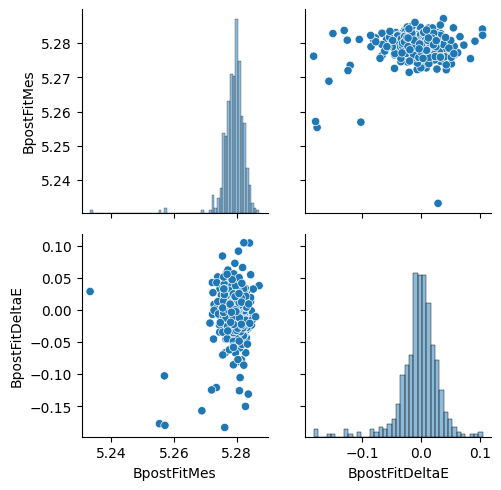

In [7]:
filter= df["spmode"]== "-999"

g= sns.PairGrid(df[filter].sample(500), vars= ["BpostFitMes","BpostFitDeltaE"], hue= "spmode")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

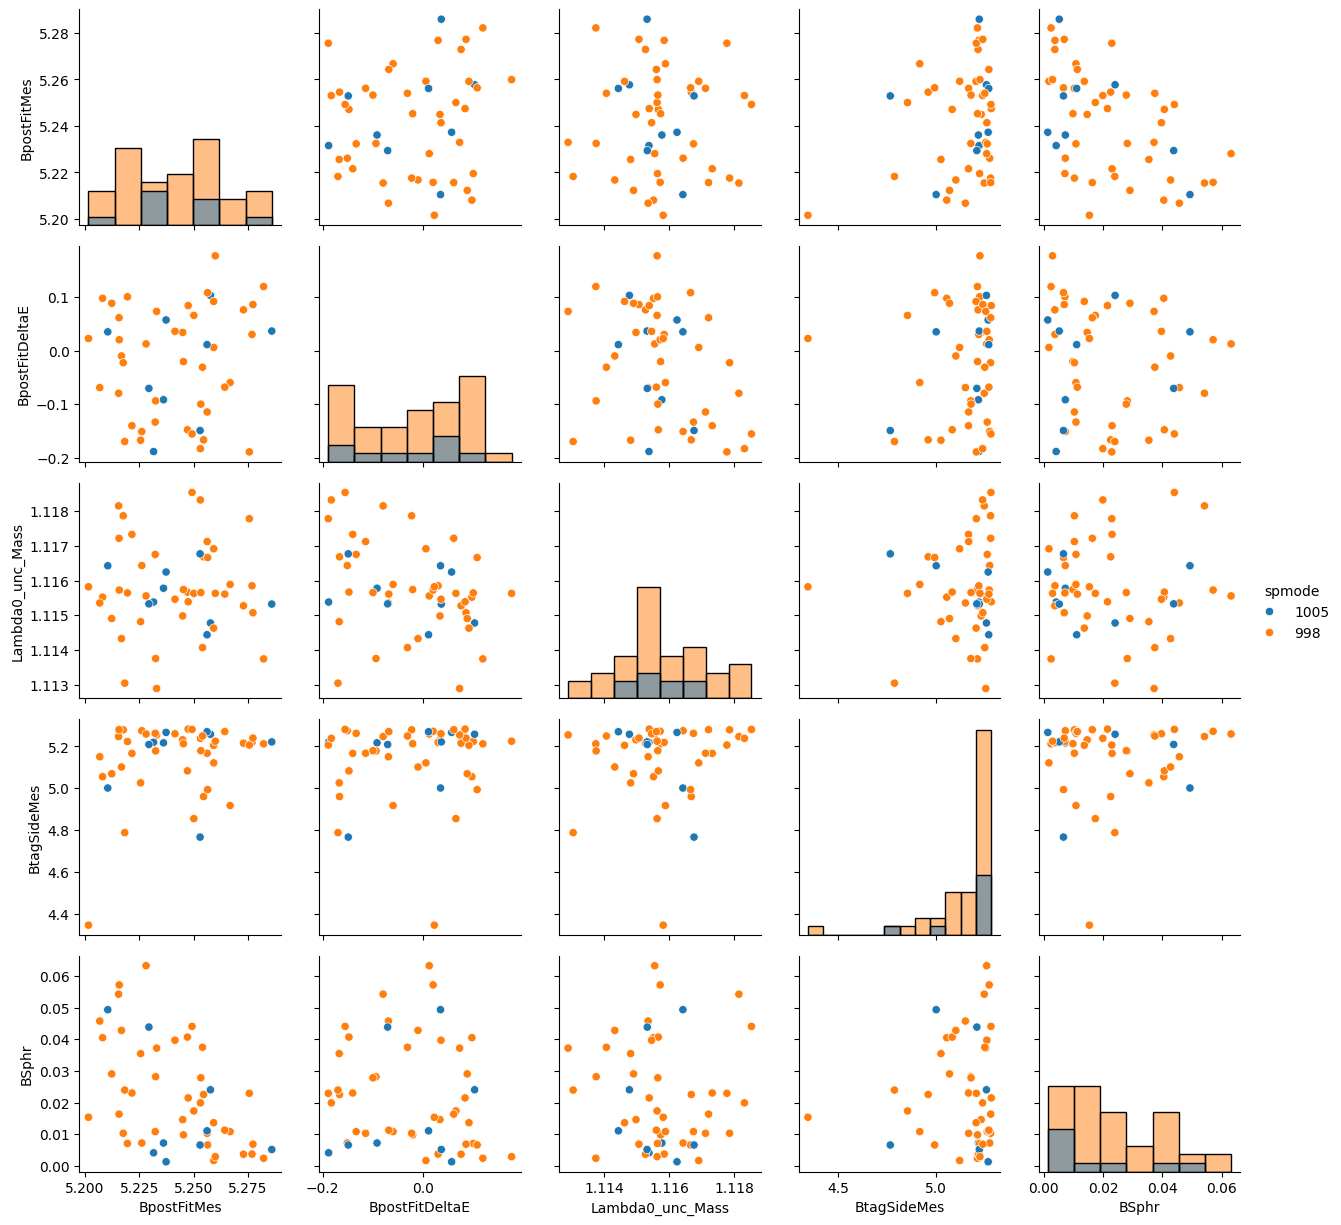

In [8]:
filter = df['spmode'] != '-999'
columns= df.columns

#g = sns.PairGrid(df[filter].sample(500), vars=['BpostFitMes', 'BpostFitDeltaE'], hue='spmode')
g = sns.PairGrid(df[filter].sample(50), vars=columns[1:6], hue='spmode')

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [9]:
feature_names= columns[1:] ##exclude spmode
print(feature_names)

Index(['BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', 'BtagSideMes',
       'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All', 'thrustMag',
       'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll',
       'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE',
       'BSphrROE', 'BThrustROE'],
      dtype='object')


In [10]:
dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

for key,val in dcuts.items():
    print(key, val['name'])

1 cut duplicates
2 fitting region
3 Lambda0 cuts / nB / nLambda
4 PID cuts
6 antiproton cuts
-1 all


In [11]:
cut1 = dcuts[1]['event']
print(len(cut1))

len(dcuts[3]['event'][cut1])

1094971


1072872

In [12]:
subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
      'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
      'R2', 'R2All', \
      'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
      'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
      'BThrustROE']

dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

mask_event= dcuts[1]["event"]# & dcuts[2]["event"] & dcuts[3]["event"] 
mask= mask_event

df_sp = bat.dump_awkward_to_dataframe(data[mask], fields_to_dump=subset)#, dropna=True)

# Put the cuts into the dataframe 
cut1 = dcuts[1]['event'] # This is the main cut that gets rid of duplicates
cuts_to_add = [2, 3, 4, 6, -1]
for cut in cuts_to_add:
    bools = dcuts[cut]['event']
    colname = f'cut_{cut}'
    print(colname, len(bools[cut1]), bools[cut1])

    df_sp[colname] = bools[cut1]

df_sp.dropna(inplace=True)


###################################
# Collision
dcuts_col= bat.get_final_masks(data_collision, region_definitions= region_definitions)

mask_event= dcuts_col[1]["event"]# & dcuts[2]["event"] & dcuts[3]["event"] 
mask= mask_event

df_col = bat.dump_awkward_to_dataframe(data_collision[mask], fields_to_dump=subset)

# Put the cuts into the dataframe 
cut1 = dcuts_col[1]['event'] # This is the main cut that gets rid of duplicates
cuts_to_add = [2, 3, 4, 6, -1]
for cut in cuts_to_add:
    bools = dcuts_col[cut]['event']
    colname = f'cut_{cut}'
    print(colname, len(bools[cut1]), bools[cut1])

    df_col[colname] = bools[cut1]

df_col.dropna(inplace=True)


df_sp

cut_2 1072872 [ True  True False ...  True  True  True]
cut_3 1072872 [ True  True False ...  True  True  True]
cut_4 1072872 [ True False False ...  True  True  True]
cut_6 1072872 [ True False False ...  True  True  True]
cut_-1 1072872 [ True False False ...  True  True  True]
cut_2 711342 [False False False ... False  True  True]
cut_3 711342 [False  True  True ...  True  True  True]
cut_4 711342 [False False False ... False False False]
cut_6 711342 [ True  True False ...  True False False]
cut_-1 711342 [False False False ... False False False]


,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE,cut_2,cut_3,cut_4,cut_6,cut_-1
0,998,5.263783,-0.189936,1.116111,5.128820,0.005330,0.998314,0.464635,0.454394,0.419195,...,0.520370,1.097943,0.169009,0.411743,0.715501,True,True,True,True,True
1,998,5.211709,-0.054256,1.115692,5.073468,0.003054,0.998590,-0.988520,0.500206,0.449933,...,0.733522,4.020535,0.203065,0.444210,0.740848,True,True,False,False,False
2,998,5.003624,0.131881,1.118121,5.128379,0.020861,0.988260,-0.863332,0.549169,0.377033,...,0.802319,2.172082,0.285400,0.405248,0.799045,False,False,False,False,False
3,998,4.090695,0.701850,1.116623,4.752428,0.020821,0.973566,-0.981012,0.701015,0.673012,...,0.550547,3.262741,0.518483,0.250978,0.896672,False,True,False,False,False
4,998,5.112355,0.349148,1.115481,5.264143,0.009250,0.983979,0.892393,0.595849,0.411979,...,0.768519,1.641515,0.157302,0.733116,0.641813,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072867,-999,5.279527,0.033336,1.114953,5.284737,0.004968,0.996235,0.691058,0.385213,0.315803,...,0.116068,1.932471,0.185726,0.344503,0.739092,True,True,True,True,True
1072868,-999,5.275526,0.000239,1.114017,5.243846,0.012021,0.995474,0.085707,0.341070,0.222305,...,0.586688,0.550932,0.229605,0.322895,0.774997,True,True,True,True,True
1072869,-999,5.276882,-0.037394,1.114870,5.257199,0.012876,0.988566,-0.329969,0.341776,0.277969,...,0.115901,0.931738,0.612370,0.093815,0.910479,True,True,True,True,True
1072870,-999,5.278979,0.003463,1.116391,5.210315,0.005293,0.997421,-0.586439,0.337755,0.299489,...,0.461186,1.063949,0.203228,0.327322,0.766174,True,True,True,True,True


In [13]:
df_col

,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE,cut_2,cut_3,cut_4,cut_6,cut_-1
0,0,4.851487,0.536608,1.118550,3.927147,0.020437,0.985893,0.962235,0.903964,0.903964,...,0.289967,2.715104,1.000000,1.040834e-16,1.000000,False,False,False,True,False
1,0,4.654816,0.348866,1.116010,4.818560,0.004547,0.994195,0.999887,0.823151,0.722719,...,0.280464,4.307044,0.526571,1.717726e-01,0.887714,False,True,False,True,False
2,0,5.159285,-0.147021,1.116692,5.202746,0.035874,0.988717,-0.935831,0.689194,0.516084,...,0.807637,2.320990,0.381448,1.875189e-01,0.834095,False,True,False,False,False
3,0,5.123064,0.000742,1.113765,5.281092,0.025991,0.988390,0.977345,0.867049,0.574683,...,0.885505,1.550588,0.526151,1.508601e-01,0.896584,False,True,False,True,False
4,0,5.173721,0.026550,1.114487,4.874539,0.024508,0.985989,0.884149,0.729804,0.495610,...,0.494894,2.775904,0.284594,2.786044e-01,0.789490,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711337,0,5.169695,-0.133828,1.115822,5.092607,0.036260,0.984972,0.994251,0.434562,0.411144,...,0.185355,2.828085,0.165578,5.951826e-01,0.723246,False,True,False,False,False
711338,0,4.918771,0.550902,1.115228,5.239137,0.013687,0.991769,0.967159,0.470193,0.335868,...,0.054969,3.331280,0.126297,4.938916e-01,0.646032,False,False,False,False,False
711339,0,4.681305,0.276864,1.117363,4.119767,0.006059,0.996728,0.960163,0.629855,0.654021,...,0.381956,2.561669,0.259178,3.388774e-01,0.769284,False,True,False,True,False
711340,0,5.242692,-0.143909,1.115869,5.267039,0.037972,0.985237,-0.893588,0.498985,0.370759,...,0.772548,2.779910,0.213933,4.600405e-01,0.757761,True,True,False,False,False


array([[<Axes: title={'center': 'BpostFitMes'}>]], dtype=object)

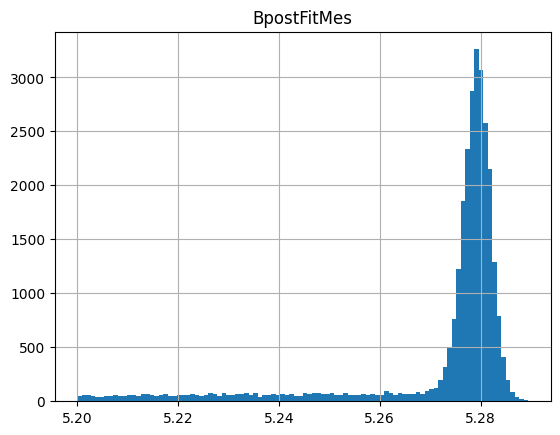

In [14]:
mask = df_sp['cut_-1'] == True
df_sp[mask].hist('BpostFitMes', bins=100)

In [15]:
# Trying out indexing

d = {"a":[1, 2, 3, 4, 5, 6], "b": [10, 20, 30, 40, 50, 60]}

dftest = pd.DataFrame.from_dict(d)


In [16]:
mask_a = dftest['a'] > 2

idx = dftest[mask].index.values
print(idx)

np.random.shuffle(idx)

dftest['b'].loc[idx]


[0]


/tmp/ipykernel_1200386/2673701443.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = dftest[mask].index.values


0    10
Name: b, dtype: int64

In [17]:
mask = df_sp['spmode'] == '-999'

idx = df_sp[mask].index.values[0:5]

#idx.values

#df['spmode'][idx]

#df.mask(

df_temp = df_sp.iloc[idx]

#df_temp.loc[41049]

In [18]:
df_sp.values.transpose()[1:]

array([[5.2637834548950195, 5.211709499359131, 5.003623962402344, ...,
        5.276881694793701, 5.278979301452637, 5.27833366394043],
       [-0.1899358481168747, -0.05425597354769707, 0.13188108801841736,
        ..., -0.03739416226744652, 0.0034627080895006657,
        -0.010767119936645031],
       [1.116110920906067, 1.115692377090454, 1.1181209087371826, ...,
        1.1148697137832642, 1.1163913011550903, 1.1134603023529053],
       ...,
       [True, False, False, ..., True, True, True],
       [True, False, False, ..., True, True, True],
       [True, False, False, ..., True, True, True]], dtype=object)

In [19]:
def my_train_test_split(df, bkg_spmode='998', sig_spmode='-999', n_sig_bkg=[1000,1000], \
                        test_size=0.4, \
                        columns_to_drop=["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"]):

    columns= df.columns

    print("columns...")
    print(columns)
    print()

    feature_names= columns[1:] ##exclude spmode
    #print(feature_names)
    
    filter_sig= df["spmode"]==sig_spmode
    filter_bkg= df["spmode"]==bkg_spmode

    # Get the indices of the sig and bkg
    idx_sig = df[filter_sig].index.values
    idx_bkg = df[filter_bkg].index.values

    print(idx_sig)
    
    # Shuffle them
    np.random.shuffle(idx_sig)
    np.random.shuffle(idx_bkg)

    #df_sig= df[filter_sig].dropna().sample(n_sig_bkg[0])
    #df_bkg= df[filter_bkg].dropna().sample(n_sig_bkg[1])

    # Amount to use for both training and testing
    n_sig = n_sig_bkg[0]
    n_bkg = n_sig_bkg[1]

    # Amount to use for testing
    n_test_sig = int(n_sig*test_size)
    n_train_sig = n_sig - n_test_sig

    # Amount to use for training
    n_test_bkg = int(n_bkg*test_size)
    n_train_bkg = n_bkg - n_test_bkg

    print("Training breakdown...")
    print(f"sig:   train: {n_train_sig}    test: {n_test_sig}") 
    print(f"bkg:   train: {n_train_bkg}    test: {n_test_bkg}") 
    
    #print(len(df_sig), len(df_bkg))
    
    #df_ML= pd.concat([df_sig,df_bkg])
    
    #x=df_ML.drop(columns= columns_to_drop)
    #y=df_ML["spmode"]

    idx_sig_train = idx_sig[0:n_train_sig]
    idx_sig_test  = idx_sig[n_train_sig:n_train_sig+n_test_sig]
    idx_sig_not_train = idx_sig[n_train_sig:]

    idx_bkg_train = idx_bkg[0:n_train_bkg]
    idx_bkg_test  = idx_bkg[n_train_bkg:n_train_bkg+n_test_bkg]
    idx_bkg_not_train = idx_bkg[n_train_bkg:]

    #print(idx_sig_train)
    
    x_sig_train = df.drop(columns=columns_to_drop).loc[idx_sig_train]
    x_sig_test  = df.drop(columns=columns_to_drop).loc[idx_sig_test]

    y_sig_train = df['spmode'].loc[idx_sig_train]
    y_sig_test  = df['spmode'].loc[idx_sig_test]

    
    x_bkg_train = df.drop(columns=columns_to_drop).loc[idx_bkg_train]
    x_bkg_test  = df.drop(columns=columns_to_drop).loc[idx_bkg_test]

    y_bkg_train = df['spmode'].loc[idx_bkg_train]
    y_bkg_test  = df['spmode'].loc[idx_bkg_test]

    # Merge them
    print("here----------------------------------------------------")
    #print(x_sig_train)
    #print(x_bkg_train)
    
    x_train = pd.concat([x_sig_train, x_bkg_train])
    x_test = pd.concat([x_sig_test,  x_bkg_test])

    #x_train = x_train.values#.transpose()[1:]
    #x_test = x_test.values#.transpose()[1:]

    #print(x_train)
    
    y_train = pd.concat([y_sig_train, y_bkg_train])
    y_test = pd.concat([y_sig_test,  y_bkg_test])

    print("The dataset (x) is the numbers without column names---")
    print("The variable y is truth info about the data (signal or bkg)\n")

    return x_train, x_test,y_train,  y_test, [idx_sig_train, idx_sig_not_train, idx_bkg_train, idx_bkg_not_train]


x_train, x_test, y_train, y_test,train_test_indices = my_train_test_split(df_sp)

print(type(x_train))
print(x_train)
print()
print(x_test)
print()
print(train_test_indices[1])
scaler= StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)


columns...
Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE', 'cut_2', 'cut_3', 'cut_4', 'cut_6',
       'cut_-1'],
      dtype='object')

[1028281 1028282 1028283 ... 1072869 1072870 1072871]
Training breakdown...
sig:   train: 600    test: 400
bkg:   train: 600    test: 400
here----------------------------------------------------
The dataset (x) is the numbers without column names---
The variable y is truth info about the data (signal or bkg)

<class 'pandas.core.frame.DataFrame'>
         BtagSideMes     BSphr   BThrust  BCosThetaS        R2     R2All  \
1052619     5.267174  0.002651  0.997505    0.238172  0.370769  0.247719   
1043752     5.232289  0.006676  0.992228    0.901961  0.601533  0.703121   
107

In [20]:
def model_maker(df, sig_spmode="-999", bkg_spmode= "998", n_sig_bkg=[1000,1000], \
                columns_to_drop=["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"], \
                test_size_pct= 0.4, activator= "relu", solve_model= "adam", model_filename=None): 
            

    #x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= test_size_pct, random_state= 4)
    x_train, x_test, y_train, y_test,train_test_indices= my_train_test_split(df, sig_spmode=sig_spmode, bkg_spmode=bkg_spmode, \
                                                          columns_to_drop=columns_to_drop, \
                                                          n_sig_bkg=n_sig_bkg, \
                                                          test_size= test_size_pct)

    feature_names = x_train.columns
    print("Feature names (model_maker)....")
    print(feature_names)
    
    # LETS TRY TO NOT DO THIS
    #scaler= StandardScaler()

    #print(type(x_train))
    #print(x_train)
    # Look in "tips for practical use"
    # https://scikit-learn.org/stable/modules/neural_networks_supervised.html
    # This also makes it no longer a DataFrame but an nxm numpy array
    #x_train= scaler.fit_transform(x_train)

    #print("x_train after........")
    #print(x_train)
    
    #x_test= scaler.transform(x_test)

    #print("x_test after..........")
    #print(x_test)
    
    model = MLPClassifier(max_iter= 1000, random_state= 3, activation= activator, solver= solve_model ) #n_iter_no_change= 15)

    model.fit(x_train, y_train)

    model.feature_names = feature_names
    
    workspace = {}
    workspace['model'] = model
    workspace['x_train'] = x_train
    workspace['y_train'] = y_train
    workspace['x_test'] = x_test
    workspace['y_test'] = y_test
    #[idx_sig_train, idx_sig_not_train, idx_bkg_train, idx_bkg_not_train]

    workspace['idx_sig_train'] = train_test_indices[0]
    workspace['idx_sig_not_train'] = train_test_indices[1]
    workspace['idx_bkg_train'] = train_test_indices[2]
    workspace['idx_bkg_not_train'] = train_test_indices[3]

    if model_filename is not None:
        joblib.dump(workspace, model_filename)

    return workspace

    

In [21]:
mask = (df_sp['cut_2']==True) & (df_sp['cut_3']==True)

df_temp = df_sp[mask]

columns_to_drop = ['cut_2', 'cut_3', 'cut_4', 'cut_6', 'cut_-1', \
                   "spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass", \
                  'BSphr', 'BThrust']
#["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"]

model_filename = "TEST_MODEL_SAVE.pkl"
workspace = model_maker(df_temp, columns_to_drop=columns_to_drop, \
                                                      n_sig_bkg=[2000, 2000], model_filename=model_filename)#, 

model = workspace['model']
x_train = workspace['x_train']
y_train = workspace['y_train']
x_test = workspace['x_test']
y_test = workspace['y_test']

model

columns...
Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE', 'cut_2', 'cut_3', 'cut_4', 'cut_6',
       'cut_-1'],
      dtype='object')

[1028281 1028282 1028283 ... 1072869 1072870 1072871]
Training breakdown...
sig:   train: 1200    test: 800
bkg:   train: 1200    test: 800
here----------------------------------------------------
The dataset (x) is the numbers without column names---
The variable y is truth info about the data (signal or bkg)

Feature names (model_maker)....
Index(['BtagSideMes', 'BCosThetaS', 'R2', 'R2All', 'thrustMag', 'thrustMagAll',
       'thrustCosTh', 'thrustCosThAll', 'sphericityAll', 'BCosSphr',
       'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE',
       'BThrus

MLPClassifier(max_iter=1000, random_state=3)

In [22]:
def plot_training_variables(df):

    #########################################################################
    # Plot the variables for the different spmodes
    #########################################################################

    print("Plotting the training variables...")
    nvars = len(df.columns)

    nrows = 5
    ncols = int(nvars / nrows) + 1
    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols)    # axes is 2d array (3x3)
    axes = axes.flatten()         # Convert axes to 1d array of length 9
    fig.set_size_inches(ncols*3, nrows*3)

    for ax, col in zip(axes, df.columns):
      sns.histplot(df, x=col, ax = ax, hue='spmode', stat='density', common_norm=False)
      ax.set_title(col)

    plt.tight_layout()

    #########################################################################
    # Plot the correlation matrices
    #########################################################################

 colmodes_in_file = df['spmode'].unique()
    # Drop the cuts columns
    cols = df_temp.columns

    cols_temp = []
    for col in cols:
        #print(col)
        if col[0:3]!='cut':
            cols_temp.append(col)
    cols_temp

    for spmode in spmodes_in_file:
        print(f"Making the correlation matrix for SP-{spmode}...")
        fig,ax = plt.subplots(figsize=(16,16))
        mask = df_temp['spmode'] == spmode
        
        sns.heatmap(df_temp[mask][cols_temp].drop(columns=['spmode']).corr(), center=0, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size": 8})
        plt.title(f'Correlation matrix SP {spmode}')        

In [23]:
'''
cols = df_temp.columns

cols = cols.to_list()

cols_temp = []
for col in cols:
    #print(col)
    if col[0:3]!='cut':
        cols_temp.append(col)

cols_temp
'''

"\ncols = df_temp.columns\n\ncols = cols.to_list()\n\ncols_temp = []\nfor col in cols:\n    #print(col)\n    if col[0:3]!='cut':\n        cols_temp.append(col)\n\ncols_temp\n"

In [24]:
#df_sp['spmode'].unique()

In [25]:
#df_sp.columns
df_sp['spmode'].value_counts()

spmode
998     726212
1005    293950
-999     44548
3429      2298
1235      2017
1237      1822
Name: count, dtype: int64

In [26]:
# Make a temporary dataframe with the cuts

mask = (df_sp['cut_2']==True) & (df_sp['cut_3']==True)

df_temp = df_sp[mask]

Plotting the training variables...
Making the correlation matrix for SP-998...
Making the correlation matrix for SP--999...


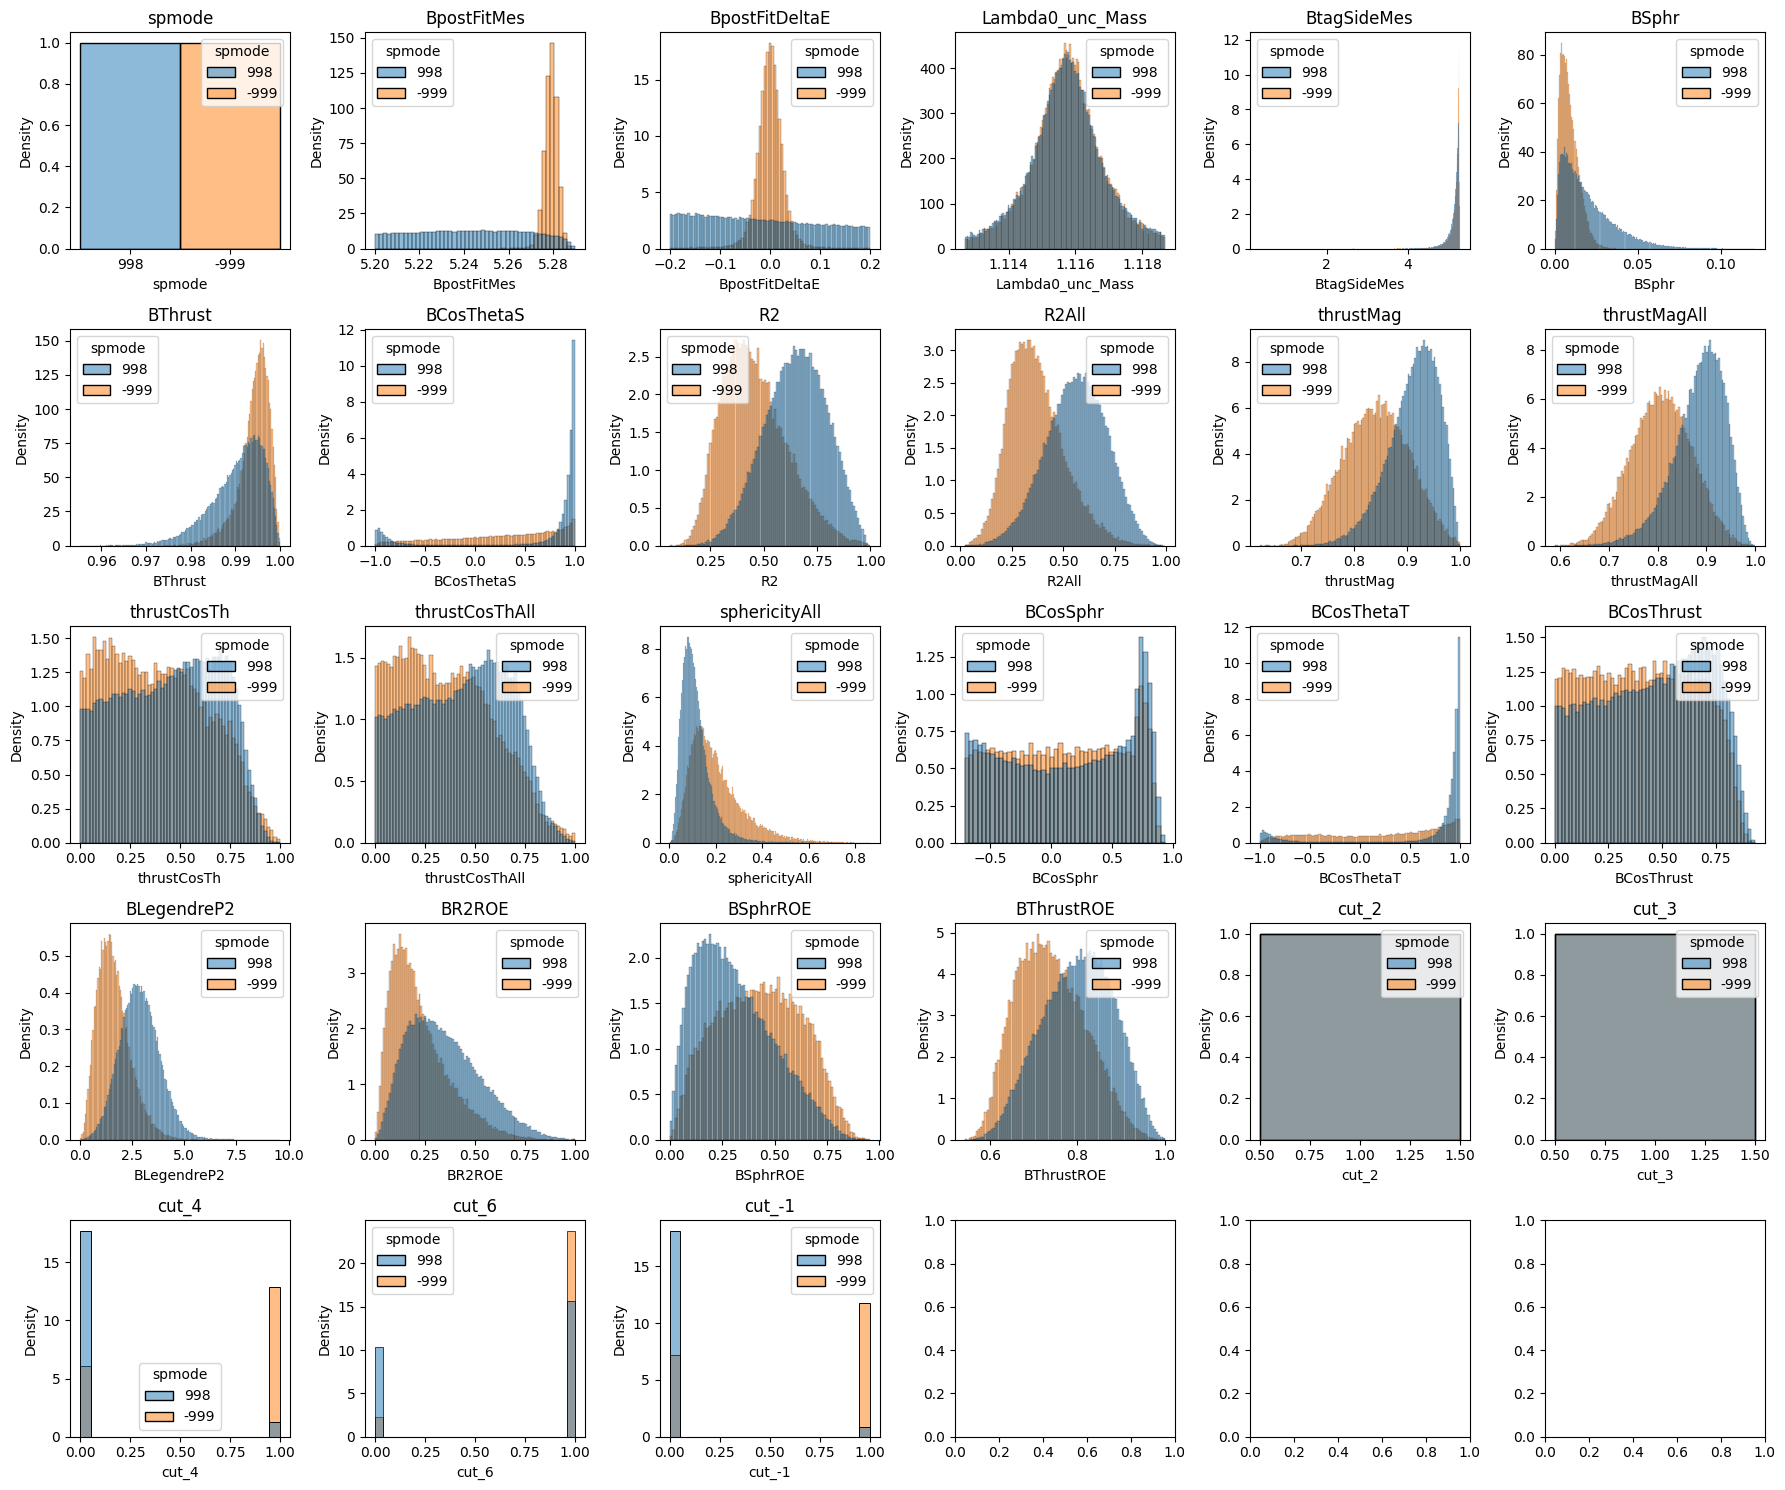

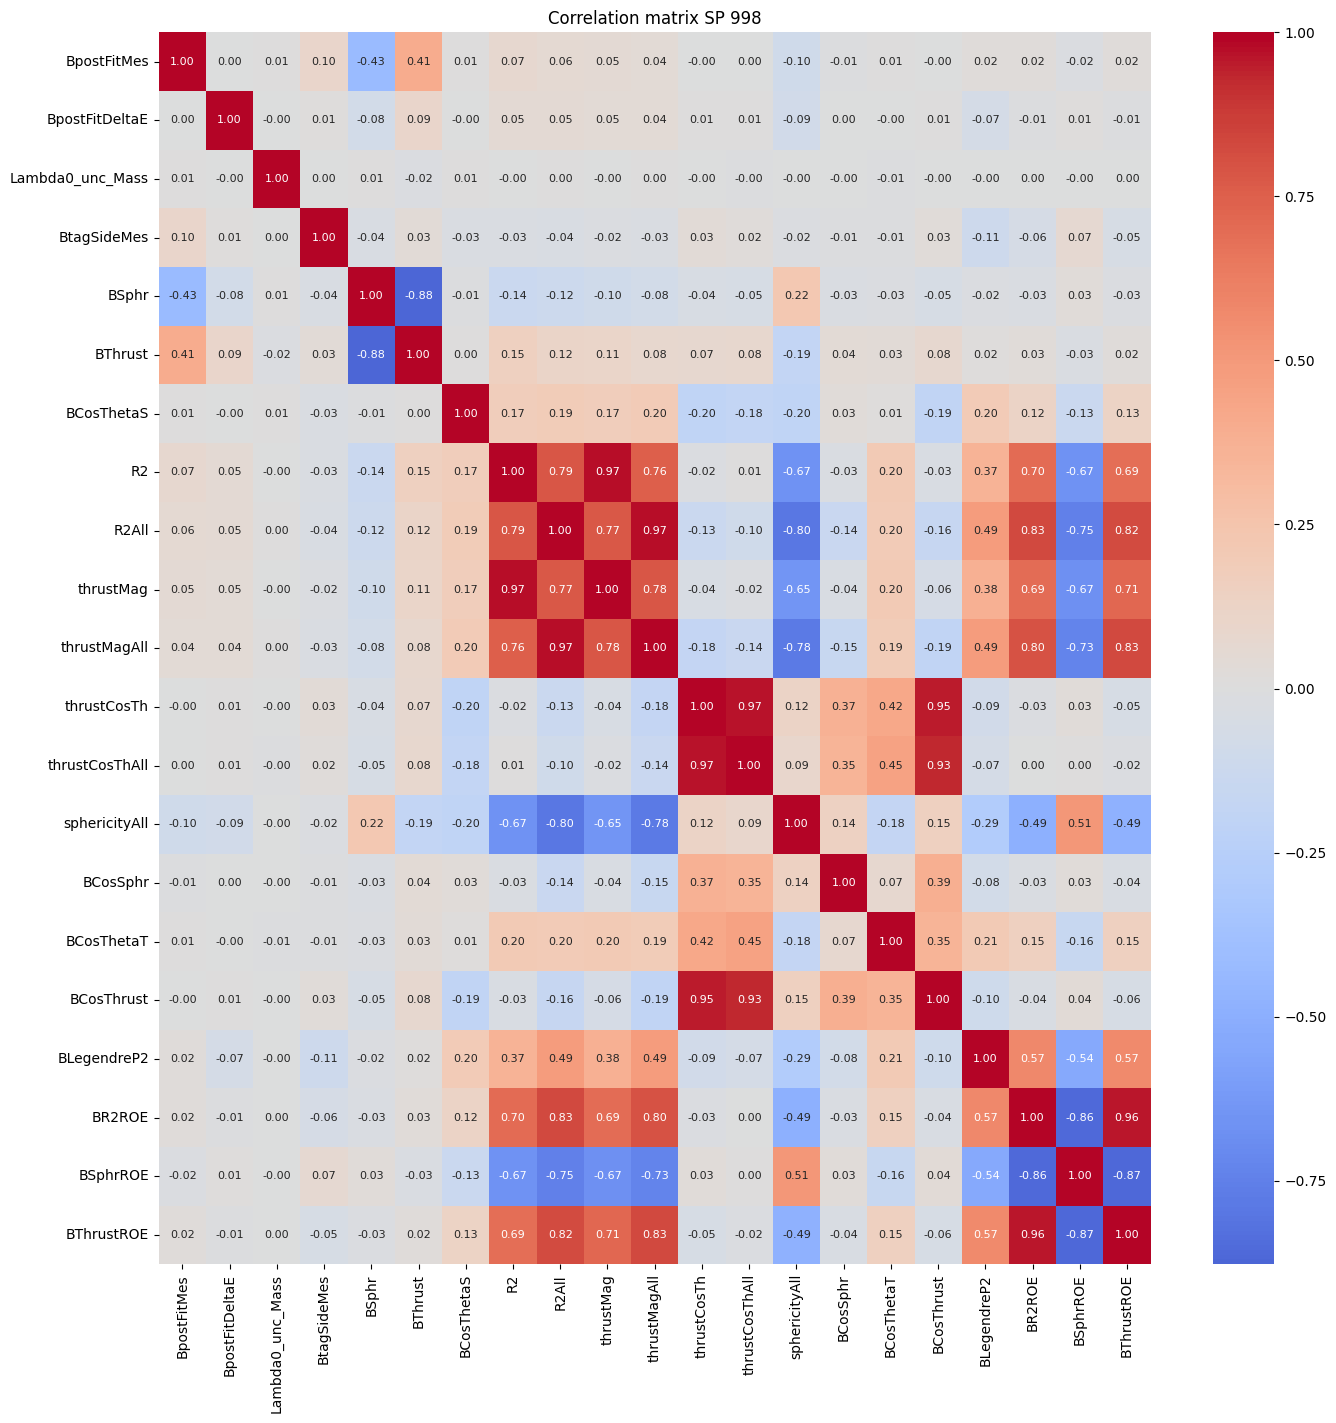

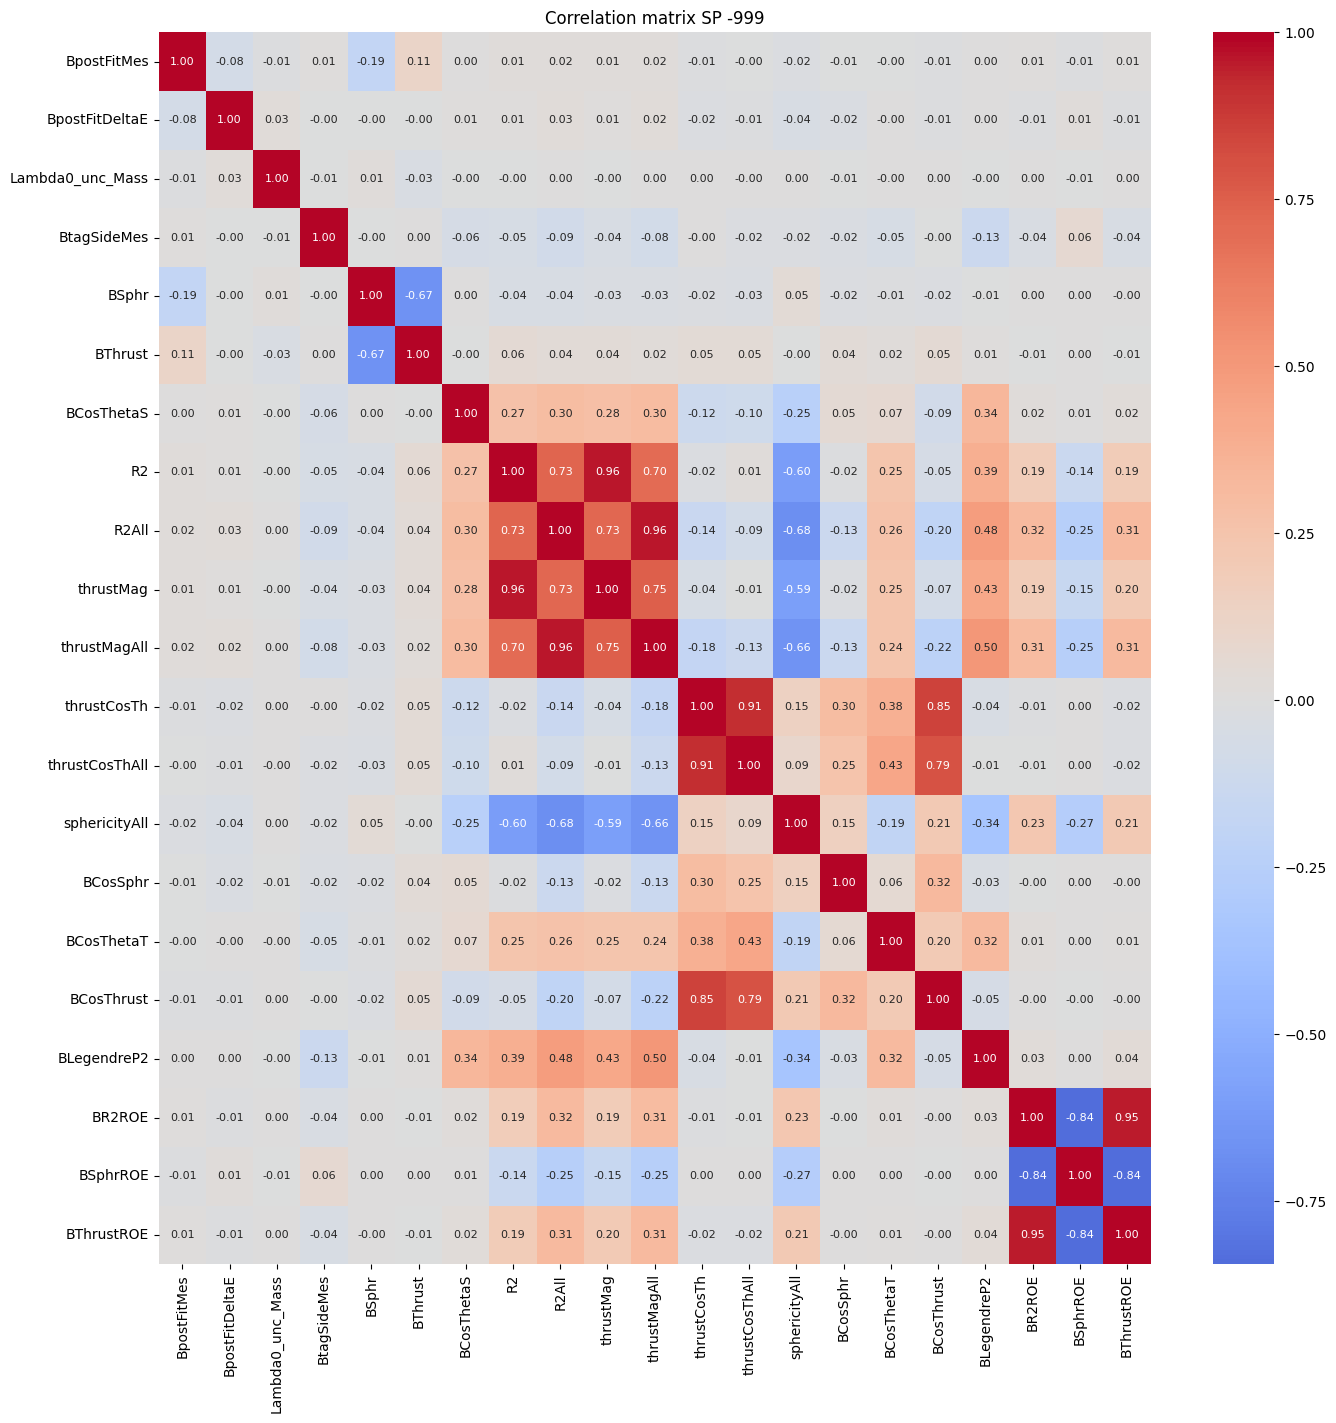

In [27]:
sp_mask = (df_temp['spmode']=='-999') | (df_temp['spmode']=='998')

plot_training_variables(df_temp[sp_mask])

In [28]:
#fig,ax = plt.subplots(figsize=(16,16))
#mask = df_temp['spmode'] == '998'
##corr = df_temp[mask].drop(columns=['spmode']).corr()
##corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

#sns.heatmap(df_temp[mask].drop(columns=['spmode']).corr(), center=0, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size": 8})

In [29]:
#mask = df_sp['spmode'] == '-999'
#corr = df_sp[mask].drop(columns=['spmode']).corr()
#corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

In [30]:
df_sp['spmode'].value_counts()

spmode
998     726212
1005    293950
-999     44548
3429      2298
1235      2017
1237      1822
Name: count, dtype: int64

In [54]:
'''
columns_to_drop = ['cut_2', 'cut_3', 'cut_4', 'cut_6', 'cut_-1', \
                   "spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass", \
                  'BSphr', 'BThrust']
#["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"]

model_filename = "TEST_MODEL_SAVE.pkl"
workspace = model_maker(df_temp, columns_to_drop=columns_to_drop, \
                                                      n_sig_bkg=[2000, 2000], model_filename=model_filename)#, 

model = workspace['model']
x_train = workspace['x_train']
y_train = workspace['y_train']
x_test = workspace['x_test']
y_test = workspace['y_test']

model
'''


mask = (df_sp['cut_2']==True) & (df_sp['cut_3']==True)

df_temp = df_sp[mask]

columns_to_drop = ['cut_2', 'cut_3', 'cut_4', 'cut_6', 'cut_-1', \
                   "spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass", \
                  'BSphr', 'BThrust']
#["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"]

model_filename = "TEST_MODEL_SAVE.pkl"
workspace = model_maker(df_temp, columns_to_drop=columns_to_drop, \
                                                      n_sig_bkg=[20000, 20000], model_filename=model_filename)#, 

model = workspace['model']
x_train = workspace['x_train']
y_train = workspace['y_train']
x_test = workspace['x_test']
y_test = workspace['y_test']

model

columns...
Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE', 'cut_2', 'cut_3', 'cut_4', 'cut_6',
       'cut_-1', 'proba'],
      dtype='object')

[1028281 1028282 1028283 ... 1072869 1072870 1072871]
Training breakdown...
sig:   train: 12000    test: 8000
bkg:   train: 12000    test: 8000
here----------------------------------------------------
The dataset (x) is the numbers without column names---
The variable y is truth info about the data (signal or bkg)

Feature names (model_maker)....
Index(['BtagSideMes', 'BCosThetaS', 'R2', 'R2All', 'thrustMag', 'thrustMagAll',
       'thrustCosTh', 'thrustCosThAll', 'sphericityAll', 'BCosSphr',
       'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE',
 

MLPClassifier(max_iter=1000, random_state=3)

In [55]:
#model

In [56]:
workspace = joblib.load('TEST_MODEL_SAVE.pkl')
#workspace

model = workspace['model']

model

MLPClassifier(max_iter=1000, random_state=3)

In [34]:
workspace

### Not done yet 

{'model': MLPClassifier(max_iter=1000, random_state=3),
 'x_train':          BtagSideMes  BCosThetaS        R2     R2All  thrustMag  thrustMagAll  \
 1064431     5.206911    0.882492  0.595762  0.474471   0.904126      0.861118   
 1037751     5.224893    0.509779  0.337283  0.301490   0.819423      0.805926   
 1059368     5.142862    0.421896  0.480451  0.578854   0.860602      0.893870   
 1047799     5.152536    0.437344  0.524680  0.354467   0.860010      0.814209   
 1041375     5.231882   -0.946646  0.485251  0.464348   0.847799      0.845281   
 ...              ...         ...       ...       ...        ...           ...   
 211738      5.052632    0.960579  0.909142  0.614468   0.984315      0.904849   
 384738      5.128906    0.991752  0.768206  0.695742   0.954881      0.937208   
 350928      5.146283    0.984018  0.765615  0.613279   0.931380      0.886279   
 391314      5.035529    0.983580  0.384672  0.348458   0.833070      0.814799   
 704382      5.252591    0.9250

In [35]:
x = np.array([10, 20, 30, 40])
np.random.shuffle(x)

x

array([10, 20, 40, 30])

In [36]:
# 
#def model_training_quality(model, x_train, y_train, x_test, y_test):
def model_training_quality(workspace):
    model = workspace['model']
    x_train = workspace['x_train']
    y_train = workspace['y_train']
    x_test = workspace['x_test']
    y_test = workspace['y_test']
    
    #model
    ###################################################################
    # Get the predictions for the training and testing samples
    ###################################################################
    decisions = []
    for X, y in ((x_train, y_train), (x_test, y_test)):

      # Use the outcome to select the truth information (>0.5 or <0.5)
      d1 = model.predict_proba(X[y == '998'])[:, 1]
      d2 = model.predict_proba(X[y == '-999'])[:, 1]
      decisions += [d1, d2]
    
    # Use this for the histogram ranges
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low, high)
    
    
    #print(decisions)
    ###################################################################
    # Make a plot of the training sample predictions
    ###################################################################

    bins = 50
    plt.figure(figsize=(12, 6))
    plt.hist(decisions[0],
              color='r', alpha=0.5, range=low_high, bins=bins,
              histtype='stepfilled', density=True,
              label='Bkg (train)')
    plt.hist(decisions[1],
              color='b', alpha=0.5, range=low_high, bins=bins,
              histtype='stepfilled', density=True,
              label='Sig (train)')
    
    
    # Make a plot with error bars for the testing samples
    hists, bins = np.histogram(decisions[2],density=True,
                              bins=bins, range=low_high)
    scale = len(decisions[2]) / sum(hists)
    err = np.sqrt(hists * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    
    plt.errorbar(center, hists, yerr=err, fmt='o', c='r', label='Bkg (test)')
    
    hists, bins = np.histogram(decisions[3],density=True,
                              bins=bins, range=low_high)
    scale = len(decisions[2]) / sum(hists)
    err = np.sqrt(hists * scale) / scale
    
    plt.errorbar(center, hists, yerr=err, fmt='o', c='b', label='Sig (test)')
    
    plt.xlabel("Classifer output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')

    # Confusion matrix
    # Testing the model i.e. predicting the labels of the test data.
    y_pred = model.predict(x_test)
    
    # Evaluating the results of the model
    accuracy = accuracy_score(y_test,y_pred)*100 ### returns the fraction of correctly classified samples 
    confusion_mat = confusion_matrix(y_test,y_pred)

    print("Accuracy for Neural Network is:",accuracy)
    print("Confusion Matrix")
    print(confusion_mat)
    
    tot_correct= confusion_mat[1][1] + confusion_mat[0][0]
    tot_wrong= confusion_mat[1][0] + confusion_mat[0][1]
    
    #print(tot_correct/(tot_correct+tot_wrong))
    
    ## The accuracy score is the total number classified correctly over the total number of classifications 


    # Turn this into a dataframe
    matrix_df = pd.DataFrame(confusion_mat)
    
    # Plot the result
    fig, ax = plt.subplots(figsize=(10,7))
    
    sns.set(font_scale=1.3)
    
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    
    #labels = df['target_names'].tolist()
    labels = ['998', '-999'] # NEED TO FIX THIS SO IT IS NOT HARDCODED
    
    # Formatting details here
    # Set axis titles
    ax.set_title('Confusion Matrix - MLP')
    ax.set_xlabel("Predicted label", fontsize =15)
    ax.set_xticklabels(labels)
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(labels, rotation = 0)
    #plt.show()

    # ROC

    decisions = model.predict_proba(x_test)[:, 1]

    ###################################################################
    # Compute ROC curve and area under the curve
    ###################################################################

    sig_bkg = np.ones_like(y_test, dtype=int)
    sig_bkg[y_test=='-999'] = 0

    fpr, tpr, thresholds = roc_curve(sig_bkg, decisions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


Accuracy for Neural Network is: 83.0875
Confusion Matrix
[[6509 1491]
 [1215 6785]]


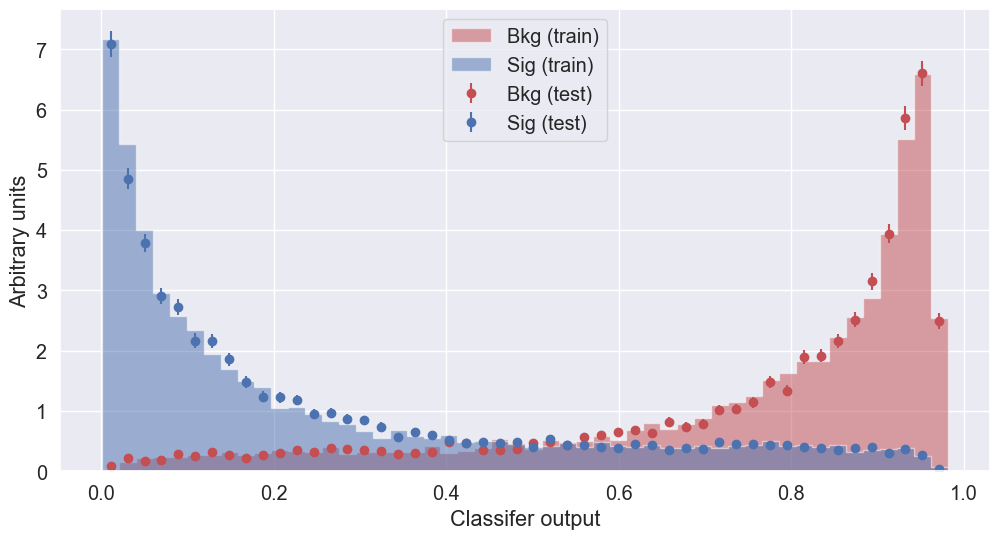

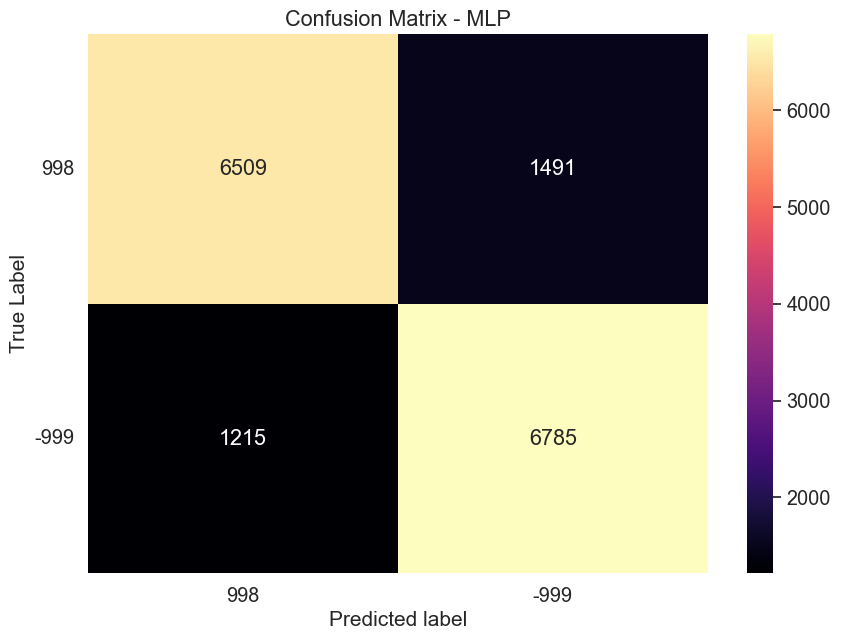

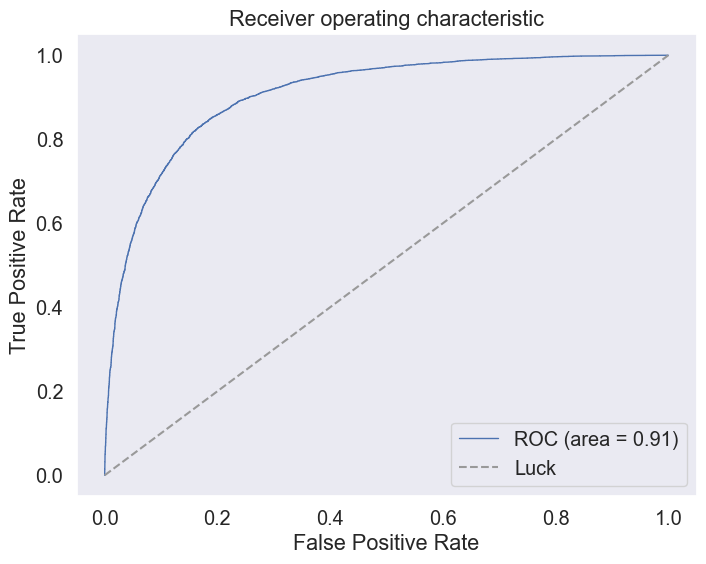

In [57]:
workspace = joblib.load('TEST_MODEL_SAVE.pkl')

model_training_quality(workspace)

In [61]:
#""""
def add_probas_to_dfs(workspace, df_col, df_sp):

    model = workspace['model']
    x_train = workspace['x_train']
    y_train = workspace['y_train']
    x_test = workspace['x_test']
    y_test = workspace['y_test']

    #idx_x_train     = workspace['idx_sig_train']
    #idx_x_not_train = workspace['idx_sig_not_train']

    # Get the training vars
    training_vars = model.feature_names

    print("Training vars: ")
    print(training_vars)
    print(len(training_vars))

    #x_train = df_col[training_vars]#[idx_x_train]

    #### FOR SP 
    #for i in threshold:
    #    output_df= see_stuff(sig_samp= sig_samp,bkg_samp= bkg_samp, thresh= i, verbose= False, df=MC_data, df_col=coll_data)

    # 3. Scale the test data using the same scaler
    #scaler = StandardScaler()

    # SHOULD THIS BE THE ACTUAL TRAINING SP
    #x_dummy = scaler.fit_transform(x_train)

    #print(x_dummy.T[-1])
    #print(len(x_dummy), len(x_dummy[0]))

    # Collision
    x_test  = df_col[training_vars].values#[idx_x_not_train]
    print(x_test.T[-1])

    #x_test = scaler.transform(x_test)

    
    proba = model.predict_proba(x_test)

    print("proba: ")
    print(proba)
    
    df_col['proba'] = proba[:,0]
    
    print(df_col.columns)

    # SP
    # Collision
    x_test  = df_sp[training_vars].values#[idx_x_not_train]
    #x_test = scaler.transform(x_test)

    print(x_test)
    
    proba = model.predict_proba(x_test)

    print("proba: ")
    print(proba)
    
    df_sp['proba'] = proba[:,0]
    
    print(df_sp.columns)

    idx_bkg_train = workspace['idx_bkg_train']
    idx_sig_train = workspace['idx_sig_train']

    nentries = len(df_sp)
    df_sp['used_in_sig_train'] = np.zeros(nentries, dtype=bool)
    df_sp.loc[idx_sig_train, "used_in_sig_train"] = True

    df_sp['used_in_bkg_train'] = np.zeros(nentries, dtype=bool)
    df_sp.loc[idx_bkg_train, 'used_in_bkg_train'] = True

    
    #x_col_proba = model.predict_proba(df_col_tmp)
    
    #### FOR COLLISION
    #y_proba_col_sig = model.predict_proba()
    
    #sp998= sp_data["spmode"]== "998"
    #N_bkg = len(sp_998_df[sp998]) ## total number of background events (sp 998) 
    #signal_before= len(sp_999_df)
    #signal_after= len(sp_999_df)
    #efficiency = signal_after/signal_before ## the accuracy of the model after training with the SP 
    #fom = efficiency(threshold)/(np.sqrt(N_bkg(threshold)+sig_disc/2))
    #return fom
    return 0
#"""

In [62]:
#df_col.dropna(inplace=True)
add_probas_to_dfs(workspace, df_col, df_sp)#.drop(columns=columns_to_drop))

df_col#.columns

Training vars: 
Index(['BtagSideMes', 'BCosThetaS', 'R2', 'R2All', 'thrustMag', 'thrustMagAll',
       'thrustCosTh', 'thrustCosThAll', 'sphericityAll', 'BCosSphr',
       'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE',
       'BThrustROE', 'proba'],
      dtype='object')
17
[0.05867274 0.04254576 0.1417781  ... 0.2761293  0.22035884 0.05788993]


/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


proba: 
[[0.052933   0.947067  ]
 [0.03758727 0.96241273]
 [0.14357553 0.85642447]
 ...
 [0.24343881 0.75656119]
 [0.21860739 0.78139261]
 [0.0502284  0.9497716 ]]
Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE', 'cut_2', 'cut_3', 'cut_4', 'cut_6',
       'cut_-1', 'proba'],
      dtype='object')
[[ 5.12882042  0.46463484  0.45439351 ...  0.41174313  0.71550059
   0.92403729]
 [ 5.07346821 -0.98851985  0.50020564 ...  0.44421014  0.74084848
   0.43349847]
 [ 5.12837887 -0.86333221  0.549169   ...  0.40524784  0.79904473
   0.38448737]
 ...
 [ 5.25719929 -0.32996941  0.34177577 ...  0.09381472  0.91047859
   0.99209537]
 [ 5.21031475 -0.58643895  0.33775467 ...  0.32732198  0.76617396
   0.96822842]
 [ 5.0969

/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


proba: 
[[0.91710997 0.08289003]
 [0.46132204 0.53867796]
 [0.36506593 0.63493407]
 ...
 [0.99183033 0.00816967]
 [0.96784131 0.03215869]
 [0.97019824 0.02980176]]
Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE', 'cut_2', 'cut_3', 'cut_4', 'cut_6',
       'cut_-1', 'proba', 'used_in_sig_train', 'used_in_bkg_train'],
      dtype='object')


,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,BLegendreP2,BR2ROE,BSphrROE,BThrustROE,cut_2,cut_3,cut_4,cut_6,cut_-1,proba
0,0,4.851487,0.536608,1.118550,3.927147,0.020437,0.985893,0.962235,0.903964,0.903964,...,2.715104,1.000000,1.040834e-16,1.000000,False,False,False,True,False,0.052933
1,0,4.654816,0.348866,1.116010,4.818560,0.004547,0.994195,0.999887,0.823151,0.722719,...,4.307044,0.526571,1.717726e-01,0.887714,False,True,False,True,False,0.037587
2,0,5.159285,-0.147021,1.116692,5.202746,0.035874,0.988717,-0.935831,0.689194,0.516084,...,2.320990,0.381448,1.875189e-01,0.834095,False,True,False,False,False,0.143576
3,0,5.123064,0.000742,1.113765,5.281092,0.025991,0.988390,0.977345,0.867049,0.574683,...,1.550588,0.526151,1.508601e-01,0.896584,False,True,False,True,False,0.099773
4,0,5.173721,0.026550,1.114487,4.874539,0.024508,0.985989,0.884149,0.729804,0.495610,...,2.775904,0.284594,2.786044e-01,0.789490,False,True,False,True,False,0.138239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711337,0,5.169695,-0.133828,1.115822,5.092607,0.036260,0.984972,0.994251,0.434562,0.411144,...,2.828085,0.165578,5.951826e-01,0.723246,False,True,False,False,False,0.146904
711338,0,4.918771,0.550902,1.115228,5.239137,0.013687,0.991769,0.967159,0.470193,0.335868,...,3.331280,0.126297,4.938916e-01,0.646032,False,False,False,False,False,0.406256
711339,0,4.681305,0.276864,1.117363,4.119767,0.006059,0.996728,0.960163,0.629855,0.654021,...,2.561669,0.259178,3.388774e-01,0.769284,False,True,False,True,False,0.243439
711340,0,5.242692,-0.143909,1.115869,5.267039,0.037972,0.985237,-0.893588,0.498985,0.370759,...,2.779910,0.213933,4.600405e-01,0.757761,True,True,False,False,False,0.218607


In [63]:
df_sp

,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,BSphrROE,BThrustROE,cut_2,cut_3,cut_4,cut_6,cut_-1,proba,used_in_sig_train,used_in_bkg_train
0,998,5.263783,-0.189936,1.116111,5.128820,0.005330,0.998314,0.464635,0.454394,0.419195,...,0.411743,0.715501,True,True,True,True,True,0.917110,False,False
1,998,5.211709,-0.054256,1.115692,5.073468,0.003054,0.998590,-0.988520,0.500206,0.449933,...,0.444210,0.740848,True,True,False,False,False,0.461322,False,False
2,998,5.003624,0.131881,1.118121,5.128379,0.020861,0.988260,-0.863332,0.549169,0.377033,...,0.405248,0.799045,False,False,False,False,False,0.365066,False,False
3,998,4.090695,0.701850,1.116623,4.752428,0.020821,0.973566,-0.981012,0.701015,0.673012,...,0.250978,0.896672,False,True,False,False,False,0.092274,False,False
4,998,5.112355,0.349148,1.115481,5.264143,0.009250,0.983979,0.892393,0.595849,0.411979,...,0.733116,0.641813,False,True,False,False,False,0.592520,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072867,-999,5.279527,0.033336,1.114953,5.284737,0.004968,0.996235,0.691058,0.385213,0.315803,...,0.344503,0.739092,True,True,True,True,True,0.880329,False,False
1072868,-999,5.275526,0.000239,1.114017,5.243846,0.012021,0.995474,0.085707,0.341070,0.222305,...,0.322895,0.774997,True,True,True,True,True,0.981700,False,False
1072869,-999,5.276882,-0.037394,1.114870,5.257199,0.012876,0.988566,-0.329969,0.341776,0.277969,...,0.093815,0.910479,True,True,True,True,True,0.991830,False,False
1072870,-999,5.278979,0.003463,1.116391,5.210315,0.005293,0.997421,-0.586439,0.337755,0.299489,...,0.327322,0.766174,True,True,True,True,True,0.967841,True,False


<Axes: >

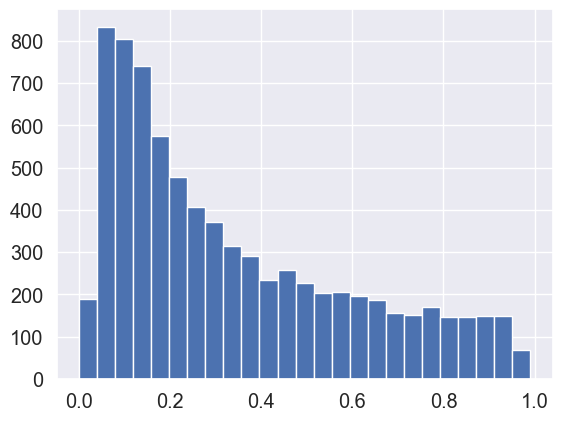

In [40]:
mask = df_col['cut_-1']==True

df_col[mask]['proba'].hist(bins=25, range=(0,0.99))
#plt.yscale('log')




In [51]:
print(workspace.keys())
workspace['idx_sig_not_train']

dict_keys(['model', 'x_train', 'y_train', 'x_test', 'y_test', 'idx_sig_train', 'idx_sig_not_train', 'idx_bkg_train', 'idx_bkg_not_train'])


array([1064230, 1030550, 1049277, ..., 1054296, 1069747, 1042448])

84010 1070847
<class 'numpy.ndarray'> [272934  30703 610783 ... 598248 172327 256551]
727767
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
       1072862, 1072863, 1072864, 1072865, 1072866, 1072867, 1072868, 1072869,
       1072870, 1072871],
      dtype='int64', length=1070847)
1072871
221179    998
8313      998
128969    998
458538    998
658599    998
361207    998
602950    998
16211     998
12505     998
422600    998
184478    998
163578    998
18268     998
595780    998
653261    998
83656     998
570688    998
36126     998
196269    998
123820    998
508505    998
486418    998
11769     998
712524    998
502438    998
88238     998
502446    998
127631    998
Name: spmode, dtype: object
[272934  30703 610783 400001 578623 281310 590738 539335 683474 476980]
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
       1072862, 1072863, 1072864, 1

,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,BLegendreP2,BR2ROE,BSphrROE,BThrustROE,cut_2,cut_3,cut_4,cut_6,cut_-1,proba
272934,998,5.252362,0.155650,1.115062,5.232926,0.019484,0.992586,0.218261,0.551115,0.520775,...,1.668995,0.151105,0.515058,0.685587,True,True,False,True,False,0.906264
30703,998,5.283011,-0.099402,1.115043,3.557564,0.006996,0.994172,0.978846,0.765148,0.704732,...,8.610741,0.654033,0.054524,0.920802,True,True,False,False,False,0.025956
610783,998,5.218188,-0.122456,1.118490,4.889336,0.041020,0.985467,0.936066,0.518542,0.418344,...,2.400156,0.152221,0.524988,0.678589,True,True,False,True,False,0.256925
400001,998,5.200391,0.010790,1.115838,5.183933,0.019969,0.993485,0.966955,0.696189,0.639399,...,4.028790,0.436935,0.316695,0.870016,True,True,False,False,False,0.064500
578623,998,5.247850,0.039664,1.116709,5.260042,0.014169,0.993719,-0.556910,0.460752,0.363357,...,1.640266,0.311857,0.357584,0.804150,True,True,False,True,False,0.751477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319361,998,5.249661,-0.152350,1.118203,5.007944,0.028542,0.989704,0.999928,0.691140,0.727853,...,4.898957,0.584418,0.105661,0.879613,True,True,False,True,False,0.037621
417483,998,5.271826,0.065041,1.113679,5.275974,0.013120,0.994449,-0.443113,0.666692,0.401556,...,0.745400,0.230457,0.474980,0.757524,True,True,False,False,False,0.734606
598248,998,5.220648,-0.013871,1.115895,5.163138,0.038348,0.979061,0.986916,0.751782,0.763705,...,2.750811,0.488934,0.162974,0.873774,True,True,False,True,False,0.075857
172327,998,5.238694,-0.087838,1.115350,4.987102,0.006012,0.995891,0.921894,0.642961,0.534954,...,2.358939,0.226736,0.188593,0.756802,True,True,False,False,False,0.335869


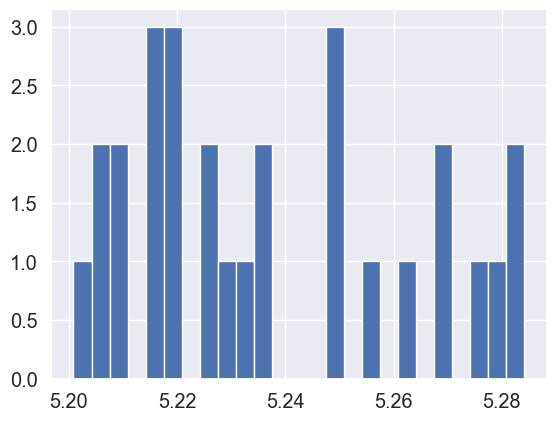

In [42]:
#for i in range(0,3):

#idx = workspace['idx_sig_not_train']
idx = workspace['idx_bkg_not_train']

print(len(idx), len(df_sp))

print(type(idx),idx)

print(max(idx))

print(df_sp.index)
print(max(df_sp.index))
#df_sp.loc[100240]
df_tmp = df_sp.loc[idx]

#for i in idx:

#    print(f"{i} {df_sp.loc[i].index}")

#'''
#spmask = (df_tmp['spmode']=='998')
#spmask = (df_tmp['spmode']=='-999')
spmask = (df_tmp['spmode']!='-999')

mask =   (df_tmp['cut_2']==True) & (df_tmp['cut_3']==True)  & (df_tmp['cut_4']==True)
mask = mask & (df_tmp['proba'] > 0.97)

#var = 'proba'
var = 'BpostFitMes'
#df_tmp[var].hist(bins=25)#, range=(0,0.99))
df_tmp[spmask & mask][var].hist(bins=25)#, range=(0,0.99))
#plt.yscale('log')

print(df_tmp[spmask & mask]['spmode'])
print(idx[0:10])
#df_sp[spmask & mask]['proba'].loc[idx[0:10]]#, range=(0,0.99))

print(df_sp.index)
#'''
;
df_tmp

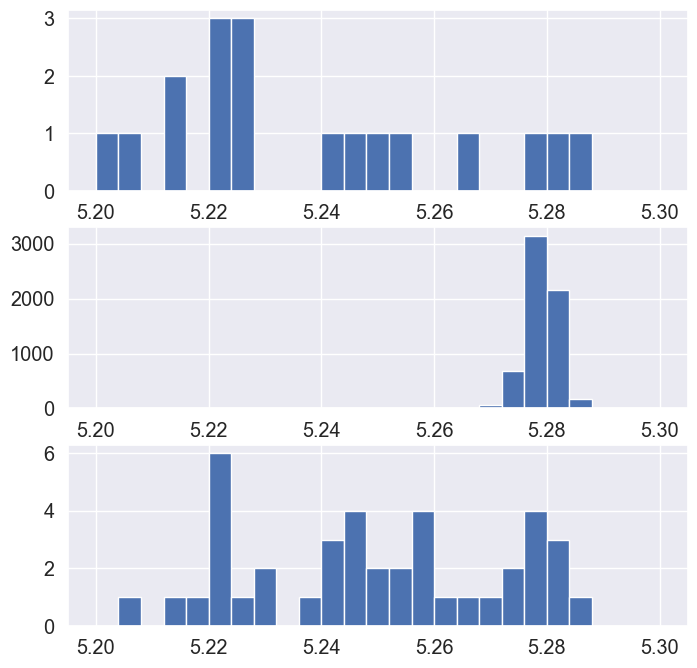

In [149]:
probacut = 0.92
plt.figure(figsize=(8,8))

for i in range(0,3):

    idx = None
    spmode = None
    df_tmp = None
    
    if i==0:
        idx = workspace['idx_bkg_not_train']
        spmode = '998'
        df_tmp = df_sp.loc[idx]

    elif i==1:
        idx = workspace['idx_sig_not_train']
        spmode = '-999'
        df_tmp = df_sp.loc[idx]
    
    elif i==2:
        spmode = '0'
        df_tmp = df_col
    
    spmask = (df_tmp['spmode']==spmode)
    
    mask =   (df_tmp['cut_2']==True) & (df_tmp['cut_3']==True)  & (df_tmp['cut_4']==True)

    mask = mask & (df_tmp['proba'] > probacut)
    
    mask = mask & (df_tmp['BpostFitDeltaE']<0.05) & (df_tmp['BpostFitDeltaE']>-0.05)
    
    #var = 'proba'
    var = 'BpostFitMes'

    plt.subplot(3,1,i+1)
    df_tmp[spmask & mask][var].hist(bins=25, range=(5.2,5.3))#, range=(0,0.99))


In [150]:
model = workspace['model']

x_train = workspace['x_train']
y_train = workspace['y_train']
y_test = workspace['y_test']

#x_train
#y_train
y_test

1063617    -999
1066347    -999
1045007    -999
1070803    -999
1048859    -999
           ... 
357547      998
516881      998
442065      998
681175      998
711549      998
Name: spmode, Length: 16000, dtype: object

In [106]:
#model.feature_names = ['hi']


In [107]:
#model.feature_names

In [115]:
dcuts.keys()

for key in dcuts.keys():
    print(f"key: {key:3d}   name: {dcuts[key]['name']}")

key:   1   name: cut duplicates
key:   2   name: fitting region
key:   3   name: Lambda0 cuts / nB / nLambda
key:   4   name: PID cuts
key:   6   name: antiproton cuts
key:  -1   name: all


In [126]:
#def punzi_fom_nn(model_aft_train, sp_data, threshold, sp_998_df, sp_999_df, sig_disc= 4, scaling= 0.3):
def punzi_fom_nn(df_sp, df_col, sig_sp_mode='-999', region_definitions = None, sigma = 4.0, BNC=False):

    # Collision data
    mask = (df_col['cut_-1'] == True) 
    if BNC is True:
        mask = (df_col['cut_2'] == True) 
        mask = mask & (df_col['cut_3'] == True) 
        mask = mask & (df_col['cut_4'] == True) 
        
    
    df_col_tmp = df_col[mask]

    # SP
    mask = (df_sp['cut_-1'] == True) 
    if BNC is True:
        mask = (df_sp['cut_2'] == True) 
        mask = mask & (df_sp['cut_3'] == True) 
        mask = mask & (df_sp['cut_4'] == True) 

    mask = mask & (df_sp['spmode'] == sig_sp_mode)
    mask = mask & (df_sp['used_in_sig_train'] == False)
    df_sp_tmp = df_sp[mask]

    meslo = region_definitions['signal MES'][0]
    meshi = region_definitions['signal MES'][1]
    
    delo = region_definitions['signal DeltaE'][0]
    dehi = region_definitions['signal DeltaE'][1]

    messidelo = region_definitions['sideband MES'][0]
    messidehi = region_definitions['sideband MES'][1]
    
    desidelo1 = region_definitions['sideband 1 DeltaE'][0]
    desidehi1 = region_definitions['sideband 1 DeltaE'][1]
    
    desidelo2 = region_definitions['sideband 2 DeltaE'][0]
    desidehi2 = region_definitions['sideband 2 DeltaE'][1]

    
    fom_dict = {}
    fom_dict['thresh'] = []
    fom_dict['nbkg_sb1'] = []
    fom_dict['nbkg_sb2'] = []
    fom_dict['nbkg'] = []
    fom_dict['nsig'] = []

    # Collision data
    mes_col = df_col_tmp['BpostFitMes']
    de_col = df_col_tmp['BpostFitDeltaE']

    mask1_col = (mes_col>messidelo) & (mes_col<messidehi) & (de_col>desidelo1) & (de_col<desidehi1)    
    mask2_col = (mes_col>messidelo) & (mes_col<messidehi) & (de_col>desidelo2) & (de_col<desidehi2)

    # SP
    mes_sp = df_sp_tmp['BpostFitMes']
    de_sp = df_sp_tmp['BpostFitDeltaE']

    mask_sp = (mes_sp>meslo) & (mes_sp<meshi) & (de_sp>delo) & (de_sp<dehi)


    for thresh in np.arange(0,1,0.01):
        
        # Collision data
        mask_thresh_col = df_col_tmp['proba'] > thresh

        nsb1 = len(df_col_tmp[mask1_col & mask_thresh_col])        
        nsb2 = len(df_col_tmp[mask2_col & mask_thresh_col])
    
        # Collision data
        mask_thresh_sp = df_sp_tmp['proba'] > thresh

        nsig = len(df_sp_tmp[mask_sp & mask_thresh_sp])        
    
        #print(nsb1, nsb2, nsig)
        
        fom_dict['thresh'].append(thresh)
        fom_dict['nbkg_sb1'].append(nsb1)
        fom_dict['nbkg_sb2'].append(nsb2)
        fom_dict['nbkg'].append((nsb1 + nsb2)/2)
        fom_dict['nsig'].append(nsig)

    df_fom = pd.DataFrame.from_dict(fom_dict)
    df_fom['sig_pct'] = df_fom['nsig'] / df_fom['nsig'].iloc[0]

    sigma = 4.0
    
    df_fom['fom'] = df_fom['sig_pct'] / (np.sqrt(df_fom['nbkg']) + sigma/2.0)

    return df_fom

In [133]:
df_fom = punzi_fom_nn(df_sp, df_col, region_definitions=region_definitions, BNC=True)

Text(0.5, 0, 'threshold')

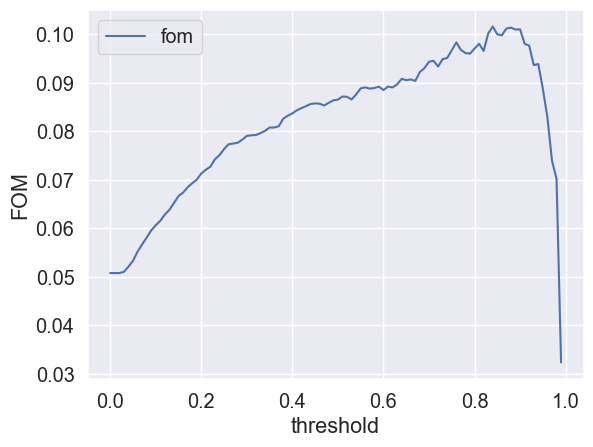

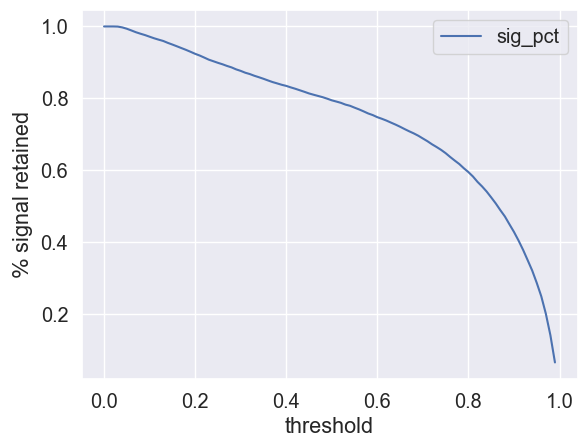

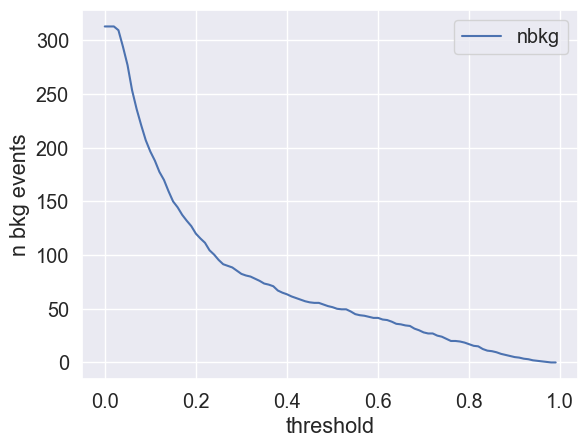

In [134]:
df_fom.plot(x='thresh', y='fom')
plt.ylabel("FOM")
plt.xlabel("threshold")


df_fom.plot(x='thresh',y='sig_pct')
plt.ylabel("$\%$ signal retained")
plt.xlabel("threshold")


df_fom.plot(x='thresh',y='nbkg')
plt.ylabel("n bkg events")
plt.xlabel("threshold")


In [136]:
fom_max = df_fom['fom'].max()

print(fom_max)

filter = df_fom['fom'] == fom_max

df_fom[filter]

0.10165338065141812


,thresh,nbkg_sb1,nbkg_sb2,nbkg,nsig,sig_pct,fom
84,0.84,9,13,11.0,9165,0.540453,0.101653


In [148]:
df_fom.sort_values(by='fom')[-20:]

,thresh,nbkg_sb1,nbkg_sb2,nbkg,nsig,sig_pct,fom
73,0.73,20,30,25.0,11268,0.664465,0.094924
74,0.74,20,28,24.0,11132,0.656445,0.095151
79,0.79,16,21,18.5,10263,0.605201,0.096046
78,0.78,17,22,19.5,10463,0.616995,0.096167
82,0.82,12,18,15.0,9621,0.567343,0.096602
75,0.75,18,26,22.0,10976,0.647246,0.096742
77,0.77,17,23,20.0,10626,0.626607,0.096816
80,0.80,13,21,17.0,10082,0.594528,0.097096
92,0.92,2,5,3.5,6413,0.378170,0.097697
91,0.91,3,6,4.5,6854,0.404175,0.098069
